In [1]:
pip install timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import zipfile
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import timm
from torch import nn, optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


In [4]:
zip_path = '/content/archive (1).zip'  # <-- Change to your zip path
extract_path = './dataset'
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset extracted.\n")

✅ Dataset extracted.



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [7]:
train_path = os.path.join(extract_path, 'train')
val_path = os.path.join(extract_path, 'val')
test_path = os.path.join(extract_path, 'test')

train_dataset = ImageFolder('/content/dataset/Data/train', transform=transform)
val_dataset = ImageFolder('/content/dataset/Data/valid', transform=transform)
test_dataset = ImageFolder('/content/dataset/Data/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [8]:
num_classes = len(train_dataset.classes)
model = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=num_classes)
model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplac

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [10]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


In [11]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # === Validation ===
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # === Epoch Output ===
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train     Loss: {avg_train_loss:.4f} | Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {avg_val_loss:.4f} | Accuracy: {val_accuracy:.2f}%")
    print("-" * 50)

Epoch 1/10
Train     Loss: 1.8456 | Accuracy: 43.39%
Validation Loss: 0.9656 | Accuracy: 48.61%
--------------------------------------------------
Epoch 2/10
Train     Loss: 0.9992 | Accuracy: 54.49%
Validation Loss: 0.9861 | Accuracy: 45.83%
--------------------------------------------------
Epoch 3/10
Train     Loss: 0.7992 | Accuracy: 64.76%
Validation Loss: 1.3410 | Accuracy: 51.39%
--------------------------------------------------
Epoch 4/10
Train     Loss: 0.6645 | Accuracy: 71.78%
Validation Loss: 0.8642 | Accuracy: 61.11%
--------------------------------------------------
Epoch 5/10
Train     Loss: 0.4683 | Accuracy: 81.57%
Validation Loss: 2.7303 | Accuracy: 43.06%
--------------------------------------------------
Epoch 6/10
Train     Loss: 0.3065 | Accuracy: 89.23%
Validation Loss: 0.9508 | Accuracy: 63.89%
--------------------------------------------------
Epoch 7/10
Train     Loss: 0.1692 | Accuracy: 96.08%
Validation Loss: 1.8945 | Accuracy: 59.72%
----------------------

In [12]:
print("\n✅ Evaluating on Test Set...")
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())



✅ Evaluating on Test Set...


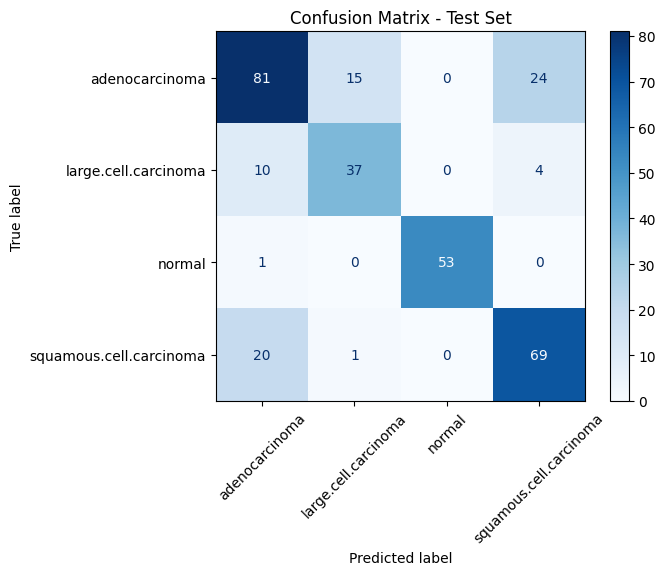

In [13]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()

In [14]:
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")


✅ Test Accuracy: 76.19%


In [15]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

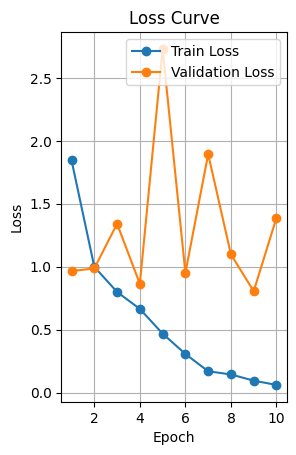

In [16]:
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

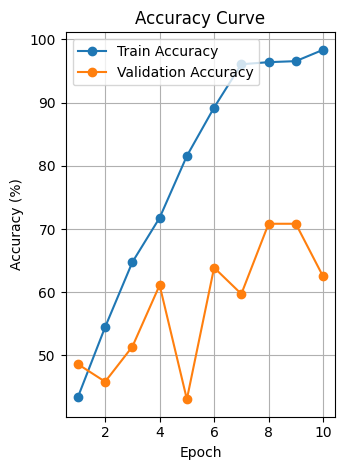

In [17]:
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()